In [82]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import numpy.random as npr
import multiprocessing
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", level=logging.INFO)

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

12


# Implementing the Node2Vec paradigm
## Algorithm
- We are given an adjacency matrix -> this acts as a set of rules (vocabulary)
- We are going to generate linear chains to be able to predict the context/neighborhood of a given node
- So, using the adjacency matrix, we generate many random walks of a fixed length.
- The random walks will become our dataset to feed and train the `SkipGram` model.

In [83]:
class Node2Vec():
        def __init__(
                        self, 
                        graph : "list[list[int]]", 
                        window_size : int, 
                        embedding_size : int, 
                        walks_per_vertex : int, 
                        walk_length : int,
                        p : float,
                        q : float
                ) -> None:
                """
                Initialize the DeepWalk model. This directly from the paper https://arxiv.org/pdf/1403.6652.pdf.

                Parameters
                ----------
                graph : list[list[int]]
                        The adjacency list to be embedded. This is a list of lists, where each list is a vertex and its neighbors.
                window_size : int
                        The window size for the skipgram model.
                embedding_size : int
                        The size of the embedding. The final output matrix will be of size |V| x embedding_size.
                walks_per_vertex : int
                        The number of walks to perform per vertex.
                walk_length : int
                        The length of each walk.
                p : float
                        The return parameter.
                q : float
                        The in-out parameter.

                Methods
                -------
                generate_n_walks()
                        Generate n walks from the graph.
                train()
                        Train the model.
                update()
                        Feed model new walks.
                get_embeddings()
                        Return the embeddings.
                """

                # DeepWalk parameters
                self.g = graph
                self.w = window_size
                self.d = embedding_size
                self.gamma = walks_per_vertex
                self.epochs = self.gamma
                self.t = walk_length
                self.n = len(graph)
                # self.removed_nodes = []
                self.p = p
                self.q = q
                
                # Cutoffs for sampling
                self.p0 = 1. / self.p / max(1., self.p, self.q)
                self.p1 = 1. /  max(1., self.p, self.q)
                self.p2 = 1. / self.q / max(1., self.p, self.q)
                
                # Make the adjacency list using the graph
                self.adj_list = []
                for i in range(len(self.g)):
                        neighbors = np.where(self.g[i] > 0)[0]  # Get neighbor indices
                        weights = self.g[i, neighbors]  # Get corresponding edge weights

                        # Sort neighbors and weights by weight
                        sorted_neighbors_weights = sorted(zip(neighbors, weights), key=lambda x: x[0])

                        # print("Look at this : ", sorted_neighbors_weights)
                        
                        # Unpack sorted_neighbors_weights using a loop
                        sorted_neighbors = [neighbor for neighbor, _ in sorted_neighbors_weights]
                        sorted_weights = [weight for _, weight in sorted_neighbors_weights]

                        # if (len(sorted_neighbors) == 0) or (len(sorted_weights) == 0):
                        #         self.removed_nodes.append(i)

                        self.adj_list.append(list(zip(sorted_neighbors, sorted_weights / np.sum(sorted_weights))))
        
        def get_random_neighbour(self, vertex : 'int') -> 'int':
                """
                Fetches a random neighbour of a given vertex
                by sampling on the basis of the edge weights
                
                Parameters
                ----------
                vertex : int
                        The vertex whose neighbour we will sample
                        
                Returns
                -------
                int
                        The neighbour that was sampled
                """
                # Sample a neighbour with probability proportional
                # to the edge weight from vertex --> neighbour
                neighbours, weights = zip(*self.adj_list[vertex])
                
                # Sample a vertex with probability proportional 
                # to the weight of the edge joining it.
                return np.random.choice(neighbours, p=weights)
                    
        def second_order_biased_random_walk(
                        self,
                        adj_mat : 'list[list[int]]', 
                        walk_len : 'int', 
                        start_node : 'int', 
                        return_parameter :'float', 
                        in_out_parameter : 'float'
                        ) -> np.array:
                """
                Return a walk based on a 2nd order Markov Chain like transition.

                Parameters
                ----------
                adj_mat : list[list[int]]
                        Adjacency matrix of the graph.
                walk_len : int
                        Length of the random walk.
                start_node : int
                        Starting node of the random walk.
                return_parameter : float
                        The value of the "p" parameter
                in_out_parameter : float
                        The value of the "q" parameter
                
                Returns
                -------
                np.array
                        List of nodes in the random walk.  
                
                """
                # Array to store the walk
                walk = [
                        start_node,
                        self.get_random_neighbour(start_node) # The prev_node is never Null
                ]

                # Generate the rest of the walk
                for i in range(2, walk_len):
                    # Variable to check whether we added to walk
                    found = False
                    new_node = None
                    
                    # Kep running until sampled in the red region
                    while not found:
                        new_node = self.get_random_neighbour(walk[-1])
                        r = np.random.rand()
                        
                        # Check if we will go back to the same node
                        if new_node == walk[-2]:
                            if r < self.p0:
                                found = True
                        
                        # Check if we are going to move by a distance of 1
                        elif self.g[walk[-2]][new_node]:
                            if r < self.p1:
                                found = True
                                    
                        else: # So we are moving by a distance of 2
                            if r < self.p2:
                                found = True
                                
                    walk.append(new_node)
            
                return walk

        def generate_n_walks(self, num_iters : int) -> 'list[list[str]]':
                """
                Generate a list of num_iters random walks. These will be used to train the model

                Parameters
                ----------
                num_iters : int
                        Number of walks to generate.

                Returns
                -------
                np.ndarray
                        List of random walks.
                """

                # List to store the walks
                walks = []
                

                # For each vertex in the graph
                for vertex in range(self.n):
                        # Generate gamma walks of length t starting from this "vertex"
                        for _ in range(self.gamma):
                                # if vertex not in self.removed_nodes:
                                # print(vertex)
                                walks.append(self.second_order_biased_random_walk(self.g, self.t, vertex, self.p, self.q))

                walks = [[str(node) for node in walk] for walk in walks]

                return walks

        def train(self, epochs : int, lr : float) -> None:
                """
                Train the model.

                Parameters
                ----------
                epochs : int
                        Number of epochs to train the model for.
                lr : float
                        Learning rate for the optimizer.                
                """          
                # Generate many walks
                walks = self.generate_n_walks(self.gamma)

                # Initialize the model
                self.model = Word2Vec(
                        walks,
                        negative= 10,
                        sg=1,
                        alpha=0.05,
                        epochs=epochs, 
                        vector_size=self.d,        # embedding dimension
                        window=self.w,             # context window size
                        min_count=0,
                        workers=2
                )

        def get_embeddings(self) -> np.ndarray:
                """
                Return the embeddings.

                Returns
                -------
                np.ndarray
                        Embeddings.
                """
                return [self.model.wv[str(n)] for n in range(self.n)]
        
        def plot_embeddings(self, num_dimensions : int, gt_labels : 'list[str]') -> None:
                """
                Plot the embeddings.

                Parameters
                ----------
                num_dimensions : int
                        Number of dimensions to plot.
                gt_labels : list[str]
                        List of ground truth labels.
                """
                embeddings = np.array(self.get_embeddings())

                # dimensionality reduction to 2 dimensions using t-SNE for visualization
                embeddings = TSNE(n_components=2).fit_transform(embeddings)

                # Convert gt into numbers
                gt_labels = np.array(gt_labels)

                # Iterate over all labels and assign them an integer
                for i, label in enumerate(np.unique(gt_labels)):
                        gt_labels[gt_labels == label] = i
                gt_labels = gt_labels.astype(int)

                # plot the embeddings
                plt.figure(figsize=(6,6))
                plt.scatter(embeddings[:,0], embeddings[:,1], c=gt_labels)

                # Plot node numbers
                for i in range(len(embeddings)):
                        plt.annotate(i , (embeddings[i,0], embeddings[i,1]))
                        
                plt.show()

In [84]:
def plot_graph ( G , node_colours):
    plt.figure(figsize=(8,8))
    # scale node size by degree
    node_sizes = [v * 20 for v in dict(G.degree()).values()]
    nx.draw_networkx(G, with_labels=False, node_color= node_colours, node_size= node_sizes,edgecolors="black", alpha=0.9)
    plt.axis("off")
    plt.show()

In [85]:
def ground_truth_loader(ground_truth_file):
    # Read data from the text file
    with open(ground_truth_file, 'r') as file:
        data = file.read()

    # Convert the data to a list of tuples representing node labels
    node_labels = [tuple(map(int, line.split())) for line in data.split('\n') if line.strip()]

    # Create a dictionary to store labels for each node
    labels_dict = {}
    for node, label in node_labels:
        labels_dict[node] = label

    # Assuming the nodes are consecutive starting from 0 to determine the number of nodes
    num_nodes = max(labels_dict.keys()) + 1

    # Generate the list of ground truth labels
    ground_truth_labels = [labels_dict[node] if node in labels_dict else None for node in range(num_nodes)]

    print("Ground Truth Labels:")
    print(ground_truth_labels)
    return ground_truth_labels

def connectivity_loader(file_name):
    # Read data from the text file
    with open(file_name, 'r') as file:
        data = file.read()

    # Convert the data to a list of tuples representing edges
    edges = [tuple(map(int, line.split())) for line in data.split('\n') if line.strip()]

    # Find the maximum node ID to determine the size of the adjacency matrix
    max_node = max(max(edge) for edge in edges) + 1

    # Initialize an empty adjacency matrix
    adj_matrix = np.zeros((max_node, max_node), dtype=int)

    # Fill the adjacency matrix based on the edges
    for edge in edges:
        u, v = edge
        adj_matrix[u][v] = 1  # For undirected graph, set both adjacencies
        adj_matrix[v][u] = 1

    print("Adjacency Matrix:")
    print(adj_matrix[:10, :10])
    return adj_matrix

In [86]:
# load the adjacency matrix
adjmat = connectivity_loader('connectivity.txt')

# Make the trace = 0
# np.fill_diagonal(adjmat, 0)

# load the ground truth data
gt_labels = ground_truth_loader('labels.txt')

# visualise the graph -> using networkx
G = nx.from_numpy_array(adjmat)

Adjacency Matrix:
[[1 1 0 0 0 1 1 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0]
 [1 0 1 0 0 1 1 1 0 0]
 [1 0 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 1 0]
 [0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 1 1]]
Ground Truth Labels:
[1, 1, 21, 21, 21, 25, 25, 14, 14, 14, 9, 14, 14, 26, 4, 17, 34, 1, 1, 14, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 5, 34, 14, 14, 17, 17, 10, 10, 36, 37, 5, 7, 4, 22, 22, 21, 21, 21, 21, 7, 7, 36, 21, 25, 4, 8, 15, 15, 15, 37, 37, 9, 1, 1, 10, 10, 3, 3, 3, 29, 15, 36, 36, 37, 1, 36, 34, 20, 20, 8, 15, 9, 4, 5, 4, 20, 16, 16, 16, 16, 16, 38, 7, 7, 34, 38, 36, 8, 27, 8, 8, 8, 10, 10, 13, 13, 6, 26, 10, 1, 36, 0, 13, 16, 16, 22, 6, 5, 4, 0, 28, 28, 4, 2, 13, 13, 21, 21, 17, 17, 14, 36, 8, 40, 35, 15, 23, 0, 0, 7, 10, 37, 27, 35, 35, 0, 0, 19, 19, 36, 14, 37, 24, 17, 13, 36, 4, 4, 13, 13, 10, 4, 38, 32, 32, 4, 1, 0, 0, 0, 7, 7, 4, 15, 16, 40, 15, 15, 15, 15, 0, 21, 21, 21, 21, 5, 4, 4

## Showing DeepWalk

In [87]:
# adjmat , window_size , embedding_size , walks_per_vertex , walk_length , p , q
# n2v = Node2Vec(adjmat, 10, 128, 5, 5, 1, 1)
p, q = 1, 0.5

n2v = Node2Vec(adjmat, 10, 128, 10, 80, p, q)

In [88]:
n2v.train(30, 0.05)

INFO - 2023-11-30 18:57:00,130: collecting all words and their counts
INFO - 2023-11-30 18:57:00,208: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-30 18:57:00,308: PROGRESS: at sentence #10000, processed 800000 words, keeping 1005 word types
INFO - 2023-11-30 18:57:00,310: collected 1005 word types from a corpus of 804000 raw words and 10050 sentences
INFO - 2023-11-30 18:57:00,311: Creating a fresh vocabulary
INFO - 2023-11-30 18:57:00,468: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 1005 unique words (100.00% of original 1005, drops 0)', 'datetime': '2023-11-30T18:57:00.443580', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-30 18:57:00,469: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 804000 word corpus (100.00% of original 804000, drops 0)', 'datetime': 

In [89]:
# # getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())

# Import standard scaler
from sklearn.preprocessing import StandardScaler

# Get the ground truth labels for the sampled nodes
gt_labels_sampled = [gt_labels[node] for node in G.nodes()]

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Standard scale
embeddings_2d = StandardScaler().fit_transform(embeddings_2d)


/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [90]:
embeddings_2d.shape

(1005, 2)

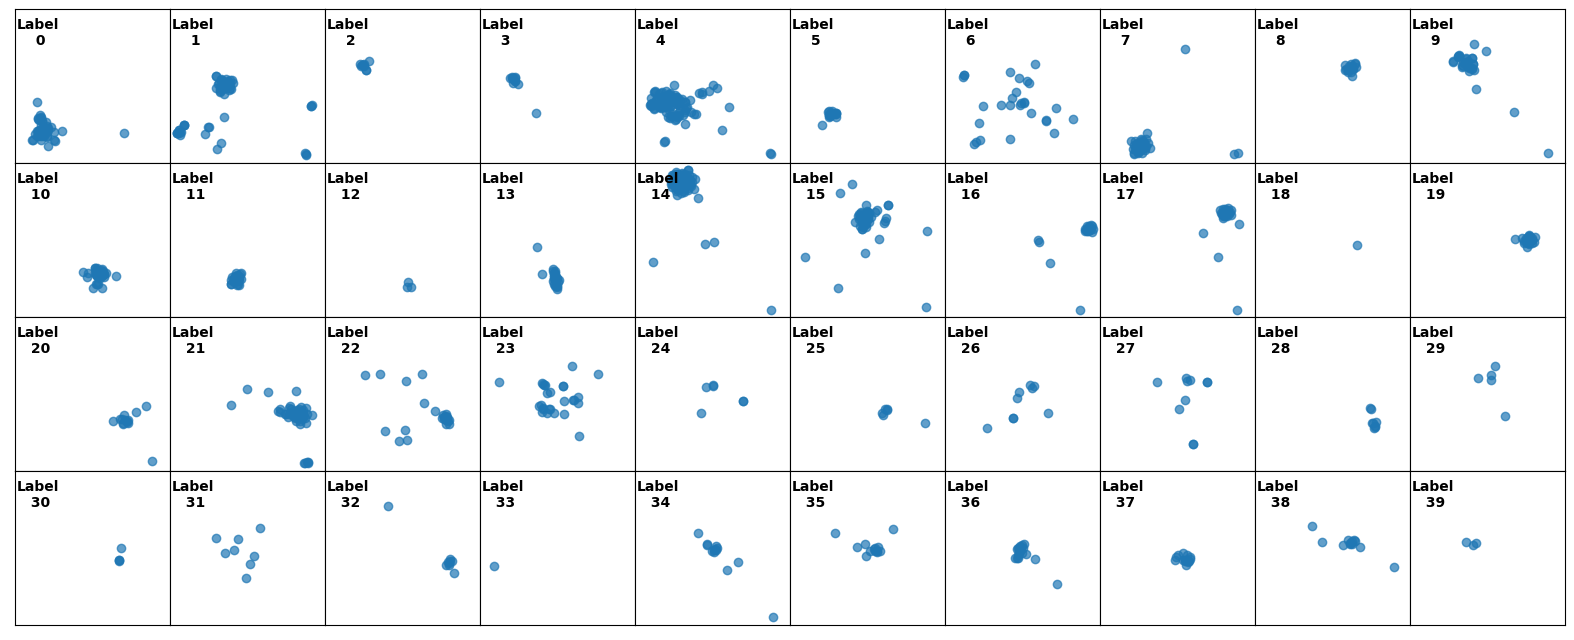

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Randomly select 16 labels
np.random.seed(42)  # Setting seed for reproducibility
selected_labels = np.arange(0, 40)

# Step 2 and 3: Create subplots and plot embeddings for each selected label
fig, axes = plt.subplots(4, 10, figsize=(20, 8), sharex='all', sharey='all')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0)

for i, label in enumerate(selected_labels):
    # Filter embeddings for the current label
    label_indices = np.where(gt_labels_sampled == label)[0]
    label_embeddings = embeddings_2d[label_indices]

    # Determine subplot position
    row, col = divmod(i, 10)

    # Scatter plot for the current label
    ax = axes[row, col]
    ax.scatter(label_embeddings[:, 0], label_embeddings[:, 1], alpha=0.7)

    # Remove ticks and axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Add label as annotation
    ax.annotate(f'Label\n {label}', xy=(0.15, 0.85), xycoords='axes fraction',
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')

plt.show()


/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


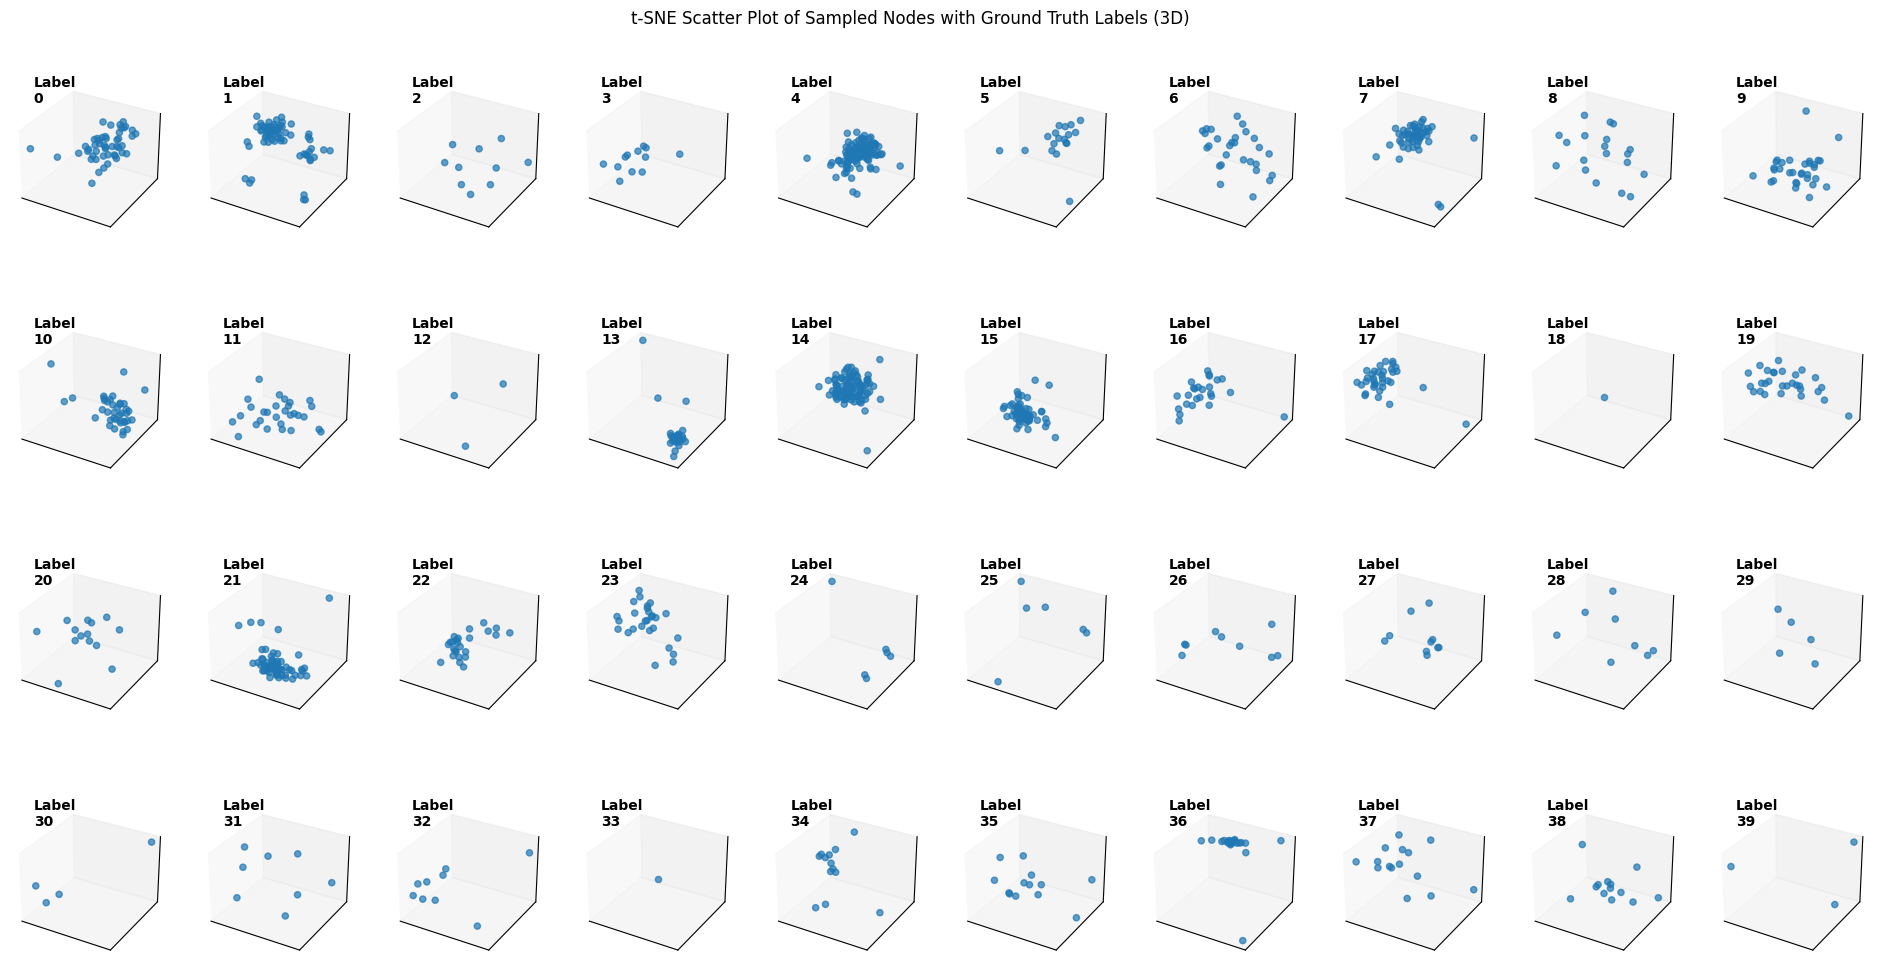

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D toolkit
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Step 1: Randomly select 16 labels
np.random.seed(42)  # Setting seed for reproducibility
selected_labels = np.arange(0, 40)

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Use t-SNE to reduce dimensions to 3D
tsne_3d = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne_3d.fit_transform(embeddings_array)

# Standard scale for 3D
embeddings_3d = StandardScaler().fit_transform(embeddings_3d)

# Create subplots and plot embeddings for each selected label
fig = plt.figure(figsize=(24, 12))
fig.suptitle('t-SNE Scatter Plot of Sampled Nodes with Ground Truth Labels (3D)', y=0.92)

for i, label in enumerate(selected_labels):
    # Filter embeddings for the current label
    label_indices = np.where(gt_labels_sampled == label)[0]
    label_embeddings = embeddings_3d[label_indices]

    # Scatter plot for the current label in 3D
    ax = fig.add_subplot(4, 10, i + 1, projection='3d')
    ax.scatter(label_embeddings[:, 0], label_embeddings[:, 1], label_embeddings[:, 2], alpha=0.7)

    # Remove ticks and axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # ax.set_xlabel('')
    # ax.set_ylabel('')
    # ax.set_zlabel('')

    # Add label as annotation
    ax.text2D(0.15, 0.85, f'Label\n{label}', transform=ax.transAxes,
              fontsize=10, color='black', fontweight='bold')

plt.show()

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D toolkit
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Provided code for Node2Vec training and getting embeddings
# ...

# Loop over p and q values
for p_value in [0.25, 1.0, 4.0]:
    for q_value in [0.25, 1.0, 4.0]:
        # Retrain Node2Vec with different p and q values
        n2v = Node2Vec(adjmat, 10, 128, 10, 80, p_value, q_value)
        n2v.train(30, 0.05)

        # Getting the embeddings from the model
        embeddings = np.array(n2v.get_embeddings())

        # Convert the list of embeddings to a NumPy array
        embeddings_array = np.array(embeddings)

        # Use t-SNE to reduce dimensions to 2D
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings_array)

        # Standard scale
        embeddings_2d = StandardScaler().fit_transform(embeddings_2d)

        # Create 2D scatter plot and save as PNG
        fig, axes = plt.subplots(4, 10, figsize=(20, 8), sharex='all', sharey='all')
        plt.subplots_adjust(wspace=0, hspace=0)

        for i, label in enumerate(selected_labels):
            label_indices = np.where(gt_labels_sampled == label)[0]
            label_embeddings = embeddings_2d[label_indices]
            row, col = divmod(i, 10)
            ax = axes[row, col]
            ax.scatter(label_embeddings[:, 0], label_embeddings[:, 1], alpha=0.7)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.annotate(f'Label\n {label}', xy=(0.15, 0.85), xycoords='axes fraction',
                        ha='center', va='center', fontsize=10, color='black', fontweight='bold')

        plt.savefig(f'tsne2D_{p_value}_{q_value}.png')
        plt.close()

        # Use t-SNE to reduce dimensions to 3D
        tsne_3d = TSNE(n_components=3, random_state=42)
        embeddings_3d = tsne_3d.fit_transform(embeddings_array)

        # Standard scale for 3D
        embeddings_3d = StandardScaler().fit_transform(embeddings_3d)

        # Create 3D scatter plot and save as PNG
        fig = plt.figure(figsize=(24, 12))
        fig.suptitle(f't-SNE Scatter Plot of Sampled Nodes with Ground Truth Labels (3D) - p={p_value}, q={q_value}', y=0.92)

        for i, label in enumerate(selected_labels):
            label_indices = np.where(gt_labels_sampled == label)[0]
            label_embeddings = embeddings_3d[label_indices]
            ax = fig.add_subplot(4, 10, i + 1, projection='3d')
            ax.scatter(label_embeddings[:, 0], label_embeddings[:, 1], label_embeddings[:, 2], alpha=0.7)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            ax.text2D(0.15, 0.85, f'Label\n{label}', transform=ax.transAxes,
                      fontsize=10, color='black', fontweight='bold')

        plt.savefig(f'tsne3D_{p_value}_{q_value}.png')
        plt.close()

INFO - 2023-11-30 19:00:15,407: collecting all words and their counts
INFO - 2023-11-30 19:00:15,408: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-30 19:00:15,496: PROGRESS: at sentence #10000, processed 800000 words, keeping 1005 word types
INFO - 2023-11-30 19:00:15,498: collected 1005 word types from a corpus of 804000 raw words and 10050 sentences
INFO - 2023-11-30 19:00:15,499: Creating a fresh vocabulary
INFO - 2023-11-30 19:00:15,502: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 1005 unique words (100.00% of original 1005, drops 0)', 'datetime': '2023-11-30T19:00:15.502908', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-30 19:00:15,504: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 804000 word corpus (100.00% of original 804000, drops 0)', 'datetime': 

INFO - 2023-11-30 19:00:49,509: EPOCH 7 - PROGRESS: at 21.14% examples, 148923 words/s, in_qsize 3, out_qsize 0
INFO - 2023-11-30 19:00:50,597: EPOCH 7 - PROGRESS: at 43.53% examples, 151167 words/s, in_qsize 3, out_qsize 0
INFO - 2023-11-30 19:00:51,615: EPOCH 7 - PROGRESS: at 65.92% examples, 155434 words/s, in_qsize 3, out_qsize 0
INFO - 2023-11-30 19:00:52,621: EPOCH 7 - PROGRESS: at 88.31% examples, 158127 words/s, in_qsize 3, out_qsize 0
INFO - 2023-11-30 19:00:53,207: EPOCH 7: training on 804000 raw words (746442 effective words) took 4.8s, 156985 effective words/s
INFO - 2023-11-30 19:00:54,240: EPOCH 8 - PROGRESS: at 21.14% examples, 152868 words/s, in_qsize 3, out_qsize 0
INFO - 2023-11-30 19:00:55,291: EPOCH 8 - PROGRESS: at 43.53% examples, 155922 words/s, in_qsize 3, out_qsize 0
INFO - 2023-11-30 19:00:56,325: EPOCH 8 - PROGRESS: at 65.92% examples, 157848 words/s, in_qsize 3, out_qsize 0
INFO - 2023-11-30 19:00:57,358: EPOCH 8 - PROGRESS: at 88.31% examples, 158918 words/

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


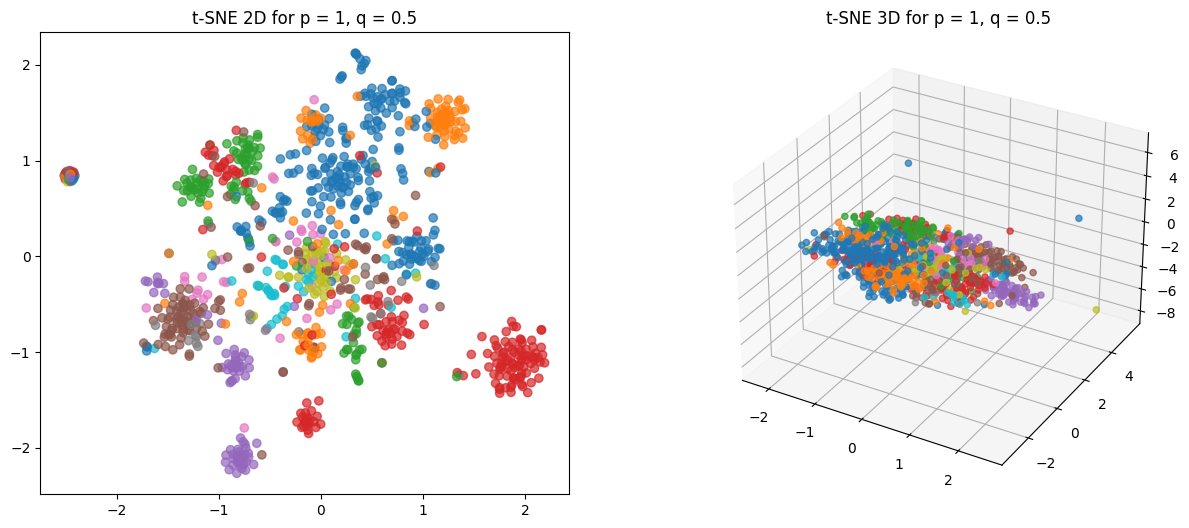

In [94]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming you have embeddings, gt_labels, and G defined before this point

# # Getting the embeddings from the model
# embeddings = np.array(n2v.get_embeddings())

# Import standard scaler
from sklearn.preprocessing import StandardScaler

# Get the ground truth labels for the sampled nodes
gt_labels_sampled = [gt_labels[node] for node in G.nodes()]

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Standard scale
embeddings_2d = StandardScaler().fit_transform(embeddings_2d)

# Use t-SNE to reduce dimensions to 3D
tsne_3d = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne_3d.fit_transform(embeddings_array)

# Standard scale for 3D
embeddings_3d = StandardScaler().fit_transform(embeddings_3d)

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot 2D t-SNE
ax1 = plt.subplot(1, 2, 1)
cmap_2d = plt.cm.get_cmap('tab10', len(np.unique(gt_labels_sampled)))
scatter_2d = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=gt_labels_sampled, cmap=cmap_2d, alpha=0.7)
unique_labels_2d = np.unique(gt_labels_sampled)
# legend_handles_2d = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_2d(i), markersize=10, label=str(i)) for i in unique_labels_2d]
# ax1.legend(handles=legend_handles_2d, title='Ground Truth Clusters')
ax1.set_title(f't-SNE 2D for p = {p}, q = {q}')


# Scatter plot in 3D
ax2 = plt.subplot(1, 2, 2, projection='3d')
cmap_3d = plt.cm.get_cmap('tab10', len(np.unique(gt_labels_sampled)))
scatter_3d = ax2.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=gt_labels_sampled, cmap=cmap_3d, alpha=0.7)
unique_labels_3d = np.unique(gt_labels_sampled)
# legend_handles_3d = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_3d(i), markersize=10, label=str(i)) for i in unique_labels_3d]
# ax2.legend(handles=legend_handles_3d, title='Ground Truth Clusters')
ax2.set_title(f't-SNE 3D for p = {p}, q = {q}')

plt.show()

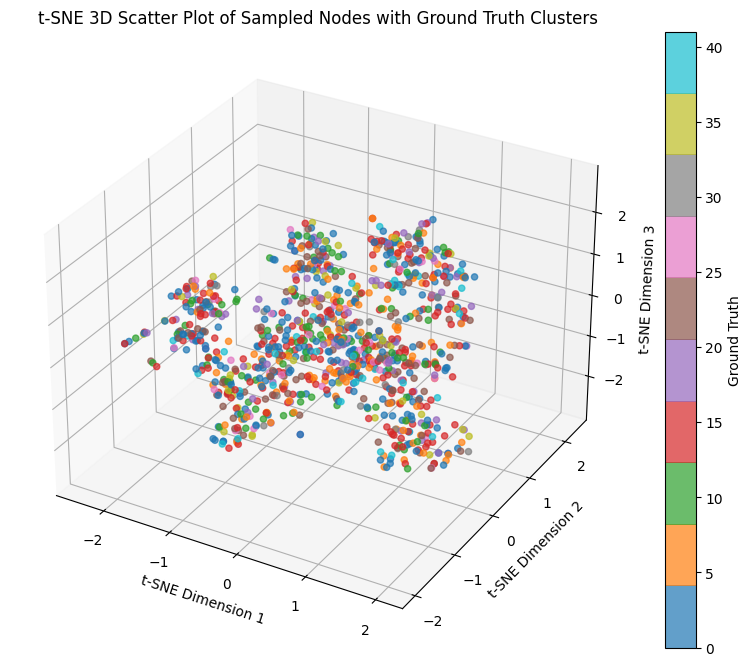

In [95]:
# # getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())

# Import standard scaler
from sklearn.preprocessing import StandardScaler

# Sample some nodes from the graph
subgraph_size = 1005  # Adjust as needed
sampled_nodes = np.random.choice(list(G.nodes()), size=subgraph_size, replace=False)

# Get the embeddings for the sampled nodes
# embeddings = [model[node] for node in sampled_nodes]

# Get the ground truth labels for the sampled nodes
gt_labels_sampled = [gt_labels[node] for node in sampled_nodes]

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Use t-SNE to reduce dimensions to 3D
tsne = TSNE(perplexity=10, n_components=3, learning_rate=20, init='random', n_iter=1000, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings_array)

# Standard scale
embeddings_3d = StandardScaler().fit_transform(embeddings_3d)

# Scatter plot in 3D with Louvain clusters as colors
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=gt_labels_sampled, cmap='tab10', alpha=0.7)
ax.set_title('t-SNE 3D Scatter Plot of Sampled Nodes with Ground Truth Clusters')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
fig.colorbar(scatter, label='Ground Truth')
plt.show()


/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


AttributeError: 'AxesSubplot' object has no attribute 'set_zlabel'

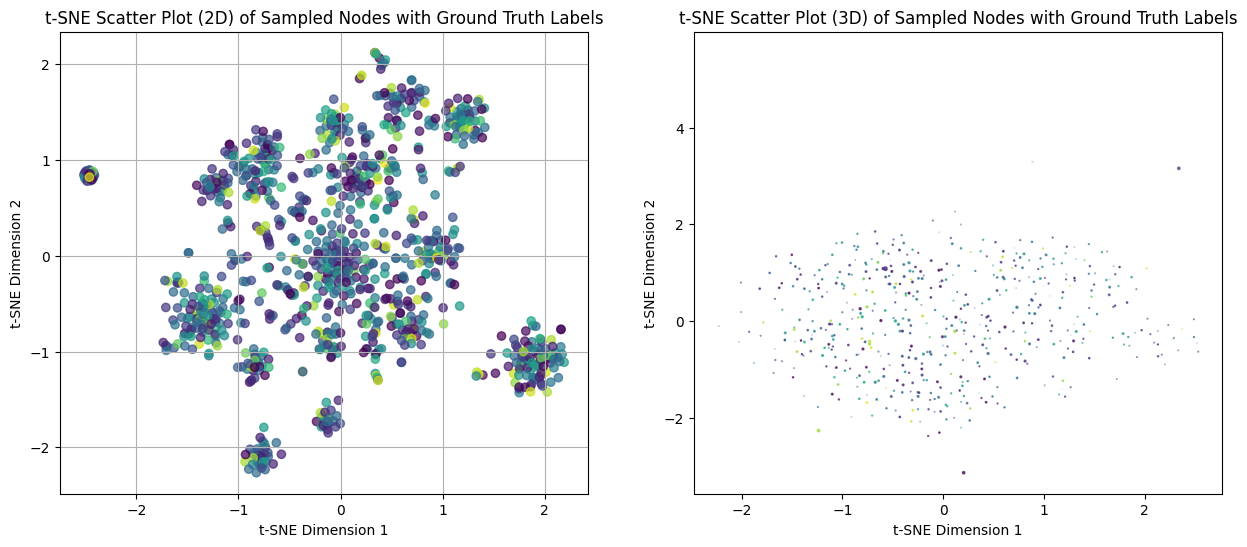

In [96]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming you have embeddings, gt_labels, and G defined before this point

# # Getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())

# Import standard scaler
from sklearn.preprocessing import StandardScaler

# Sample some nodes from the graph
subgraph_size = 1005  # Adjust as needed
sampled_nodes = np.random.choice(list(G.nodes()), size=subgraph_size, replace=False)

# Get the ground truth labels for the sampled nodes
gt_labels_sampled = [gt_labels[node] for node in sampled_nodes]

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Standard scale
embeddings_2d = StandardScaler().fit_transform(embeddings_2d)

# Use t-SNE to reduce dimensions to 3D
tsne_3d = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne_3d.fit_transform(embeddings_array)

# Standard scale for 3D
embeddings_3d = StandardScaler().fit_transform(embeddings_3d)

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot in 2D
axs[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=gt_labels_sampled, cmap='viridis', alpha=0.7)
axs[0].set_title('t-SNE Scatter Plot (2D) of Sampled Nodes with Ground Truth Labels')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
axs[0].grid(True)

# Scatter plot in 3D
axs[1].scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=gt_labels_sampled, cmap='viridis', alpha=0.7)
axs[1].set_title('t-SNE Scatter Plot (3D) of Sampled Nodes with Ground Truth Labels')
axs[1].set_xlabel('t-SNE Dimension 1')
axs[1].set_ylabel('t-SNE Dimension 2')
axs[1].set_zlabel('t-SNE Dimension 3')
axs[1].grid(True)

plt.show()


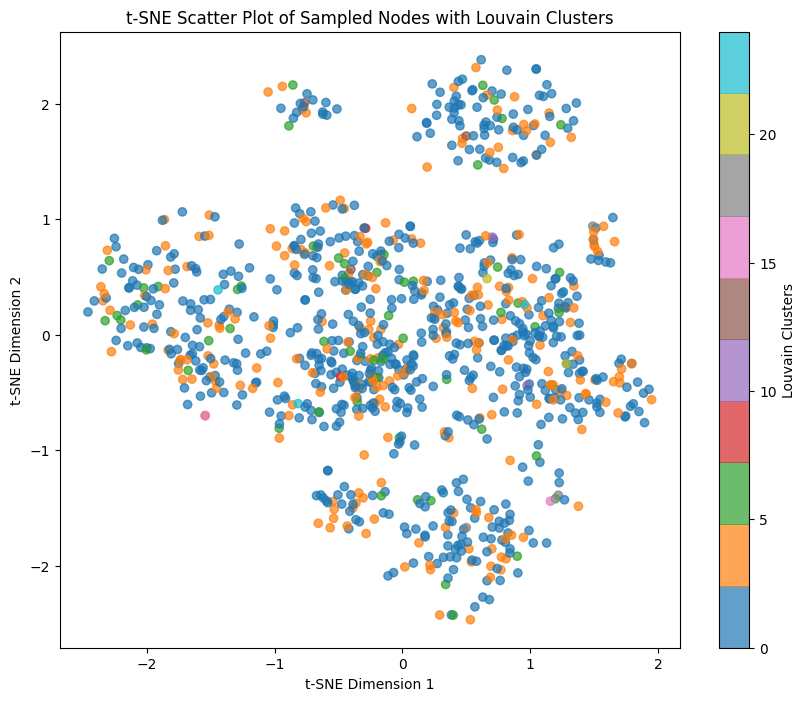

In [ ]:
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sknetwork.clustering import Louvain, get_modularity

louvain = Louvain()

# Assuming you have 'G' (the graph), 'gt_labels', and 'n2v' (the node2vec model)

# Convert the graph to an adjacency matrix
adjmat = nx.adjacency_matrix(G).todense()

# Perform Louvain vertex modularity clustering
labels = louvain.fit_predict(adjmat)

# Getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())

# Sample some nodes from the graph
subgraph_size = 1005  # Adjust as needed
sampled_nodes = np.random.choice(list(G.nodes()), size=subgraph_size, replace=False)

# Get the embeddings for the sampled nodes
embeddings_array = np.array([embeddings[node] for node in sampled_nodes])

# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(perplexity=10, n_components=3, learning_rate=20, init='random', n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Standard scale
embeddings_2d = StandardScaler().fit_transform(embeddings_2d)

# Scatter plot in 2D with Louvain clusters as colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.title('t-SNE Scatter Plot of Sampled Nodes with Louvain Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, label='Louvain Clusters')
plt.show()

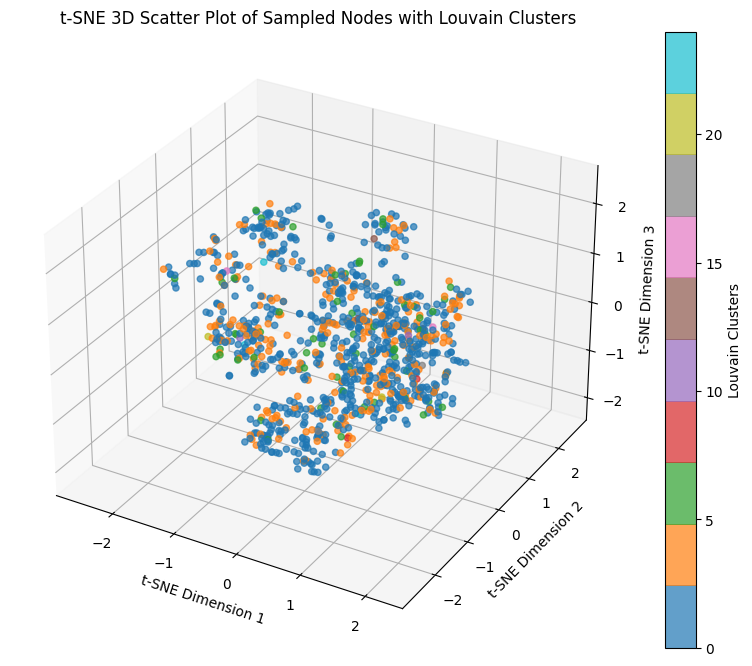

In [ ]:
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit
from sknetwork.clustering import Louvain

louvain = Louvain()

# Assuming you have 'G' (the graph), 'gt_labels', and 'n2v' (the node2vec model)

# Convert the graph to an adjacency matrix
adjmat = nx.adjacency_matrix(G).todense()

# Perform Louvain vertex modularity clustering
labels = louvain.fit_predict(adjmat)

# Getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())

# Sample some nodes from the graph
subgraph_size = 1005  # Adjust as needed
sampled_nodes = np.random.choice(list(G.nodes()), size=subgraph_size, replace=False)

# Get the embeddings for the sampled nodes
embeddings_array = np.array([embeddings[node] for node in sampled_nodes])

# Use t-SNE to reduce dimensions to 3D
tsne = TSNE(perplexity=10, n_components=3, learning_rate=20, init='random', n_iter=1000, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings_array)

# Standard scale
embeddings_3d = StandardScaler().fit_transform(embeddings_3d)

# Scatter plot in 3D with Louvain clusters as colors
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=labels, cmap='tab10', alpha=0.7)
ax.set_title('t-SNE 3D Scatter Plot of Sampled Nodes with Louvain Clusters')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
fig.colorbar(scatter, label='Louvain Clusters')
plt.show()

In [ ]:
# # getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())

# Import standard scaler
from sklearn.preprocessing import StandardScaler

# Sample some nodes from the graph
subgraph_size = 1005  # Adjust as needed
sampled_nodes = np.random.choice(list(G.nodes()), size=subgraph_size, replace=False)

# Get the embeddings for the sampled nodes
# embeddings = [model[node] for node in sampled_nodes]

# Get the ground truth labels for the sampled nodes
gt_labels_sampled = [gt_labels[node] for node in sampled_nodes]

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Standard scale
embeddings_2d = StandardScaler().fit_transform(embeddings_2d)

# Scatter plot in 2D
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=gt_labels_sampled, cmap='viridis', alpha=0.7)
plt.title('t-SNE Scatter Plot of Sampled Nodes with Ground Truth Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()